# Содержание

>[Содержание](#scrollTo=Xbl-lw6s82NU)

>[Домашнее задание](#scrollTo=X16ISPE9mN2v)

>>[1 Импорт необходимых библиотек](#scrollTo=iUgfIP2bmfUa)

>>>[1.2 Проверка подключения к GPU](#scrollTo=ArnaGn2_odPM)

>>[2 Описание необходимых функций и классов](#scrollTo=D2imz-ZVwRRn)

>>[3 Создание датасета](#scrollTo=M53rUu5ZoZr9)

>>[4 Запись датасета в Dataloader](#scrollTo=1dJSXox0uwQI)

>>[5 Определение гиперпараметров](#scrollTo=UDurv90c4Q_M)

>>[6 Определение генератора](#scrollTo=LlsSmR2kvUkH)

>>[7 Определение дискриминатора](#scrollTo=w1z7kvw_w9bs)

>>[8 Определение оптимизаторов и функции потерь](#scrollTo=pHznV8KdB8hi)

>>[9 Обучение модели](#scrollTo=usdlR1IPgxNI)

>>[10 Визуализация графика](#scrollTo=1MVdfIy076_X)



# Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

## 1 Импорт необходимых библиотек

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

### 1.2 Проверка подключения к GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2 Описание необходимых функций и классов

In [ ]:
"""Description of class Dataset"""
class Data(Dataset):
    def __init__(self, function, min_value, max_value, sequence_lenght):
        self.sequence_lenght = sequence_lenght
        self.data = np.random.rand(sequence_lenght) * (max_value - min_value) + min_value
        self.function = function

    def __len__(self):
        return self.sequence_lenght

    def __getitem__(self, idx):
        point = self.data[idx]
        return torch.Tensor([point, self.function(point)])

"""Description function of calculation"""
def MyFun(x):
    return np.sin(x)/x - x/10

"""Description of Generator's class"""
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.fc1 = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(output_size, output_size // 2)
        self.fc3 = nn.Linear(output_size // 2, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        return x

"""Description of Discriminator's class"""
class Discriminator(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.fc1 = nn.Linear(input_shape, output_shape)
        self.fc2 = nn.Linear(output_shape, output_shape // 2)
        self.fc3 = nn.Linear(output_shape // 2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

def model_train(epochs: int, data_loader, device, input_size: int, losses, g_opt, d_opt, MIN: int, MAX: int):
    """
    :param epochs: int - quantity epochs
    :param data_loader: like torch.utils.data.DataLoader
    :param device: 'cuda' if torch.cuda.is_available() else 'cpu'
    :param input_size: int: used for Generator
    :param losses: like torch.nn.BCELoss()
    :param g_opt: like torch.optim.Adam(yours params)
    :param d_opt: like torch.optim.Adam(yours params)
    :param MIN: int: min value for x axis
    :param MAX: int: max value for x axis
    :param my_fun: like:
        >>> def MyFun(x):
        >>>     return np.sin(x)/x - x/10
    :return discrim_loss_list, gen_loss_list
    """

    discrim_loss_list = []
    gen_loss_list = []

    for epoch in range(epochs):

        dis_loss_mean = 0.0
        gen_loss_mean = 0.0

        for i_data in data_loader:
            batch_size = len(i_data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
            valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
            fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

            real_data = i_data.type(torch.Tensor).to(device)

######################  Тренировка дискриминатора    ##########################

            """ 1 Генерация шума"""
            noize = torch.FloatTensor(np.random.normal(0, 1, (batch_size, input_size))).to(device)

            """ 2 Получение данных на основе шума"""
            data_gen = generator(noize)

            """ 3 Получаем предсказания дискриминатора на основе реальных данных"""
            real_disc_pred = discrimenator(real_data)

            """ 4 Сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими"""
            calc_real_loss = losses(real_disc_pred, valid)

            """ 5 Подаем сгенерированые данные на Дискриминатор"""
            fake_pred = discrimenator(data_gen)

            """ 6 Расчитываем ошибку предсказанного с фейковыми лейблами"""
            calc_fake_loss = losses(fake_pred, fake)

            """ 7 Усредняем результы потерь"""
            mean_d_loss = (calc_real_loss + calc_fake_loss) / 2

            """ 8 Обнуление градиента дискриминатора"""
            d_opt.zero_grad()
            """ 9 Обратный проход"""
            mean_d_loss.backward()
            """ 10 Шаг оптимизатора"""
            d_opt.step()

######################  Тренировка генератора    ##########################

            """ 1 Генерация шума"""
            noize = torch.Tensor(np.random.normal(0, 1, (batch_size, input_size))).to(device)

            """ 2 Получение данных на основе шума"""
            data_gen = generator(noize)

            """ 3 Подаем сгенерированые данные на Дискриминатор"""
            fake_pred = discrimenator(data_gen)

            """ 4 Сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими"""
            calc_real_g_loss = losses(fake_pred, valid)

            """ 5 Обнуление градиента дискриминатора"""
            g_opt.zero_grad()
            """ 6 Обратный проход"""
            calc_real_g_loss.backward()
            """ 7 Шаг оптимизатора"""
            g_opt.step()

            dis_loss_mean += mean_d_loss.item()
            gen_loss_mean += calc_real_g_loss.item()



        if ((epoch + 1) % 10 == 0 and (epoch + 1) < 100)  or ((epoch + 1) % 100) == 0:
            print(f"Epoch: {epoch + 1}; "\
                    f"Discriminator_loss: {'{:.3f}'.format(dis_loss_mean / len(data_loader))}; "\
                    f"Generator_loss: {'{:.3f}'.format(gen_loss_mean / len(data_loader))}")

            plt.figure(figsize = (10,5))
            plt.title('Prediction', fontsize = 20)
            plt.grid(True)
            plt.ylabel('Y', fontsize = 15)
            plt.xlabel('X', fontsize = 15)

            data_gen = data_gen.cpu().detach().numpy()
            plt.plot(data_gen[:,0], data_gen[:,1], 'o', label='data_gen')

            plt.plot(np.linspace(MIN, MAX, 100), MyFun(np.linspace(MIN, MAX, 100)), label='real_data')

            plt.legend(fontsize = 15)
            plt.show()

        discrim_loss_list.append(dis_loss_mean / len(data_loader))
        gen_loss_list.append(gen_loss_mean / len(data_loader))
    return discrim_loss_list, gen_loss_list

## 3 Создание датасета

In [ ]:
data = Data(MyFun, -20, 20, 10000)
data[0]

tensor([18.3512, -1.8612])

## 4 Запись датасета в Dataloader

In [ ]:
data_loader = DataLoader(data, batch_size=1000, shuffle=True)

## 5 Определение гиперпараметров

In [ ]:
num_epochs = 1200 # Количество эпох
lr_opt = 0.001 # Шаг обучения оптимизатора

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

## 6 Определение генератора

In [ ]:
generator = Generator(1, 64).to(device)

## 7 Определение дискриминатора

In [ ]:
discrimenator = Discriminator(2, 64).to(device)

## 8 Определение оптимизаторов и функции потерь

In [ ]:
# @title ### 8.1 Оптимизатор для генератора
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_opt, betas=(b1, b2))

In [ ]:
# @title ### 8.2 Оптимизатор для дискриминатора
disc_optimizer = torch.optim.Adam(discrimenator.parameters(), lr=lr_opt, betas=(b1, b2))

In [ ]:
# @title ### 8.3 Функция потерь
common_loss = torch.nn.BCELoss()

## 9 Обучение модели

Epoch: 10; Discriminator_loss: 0.519; Generator_loss: 0.947


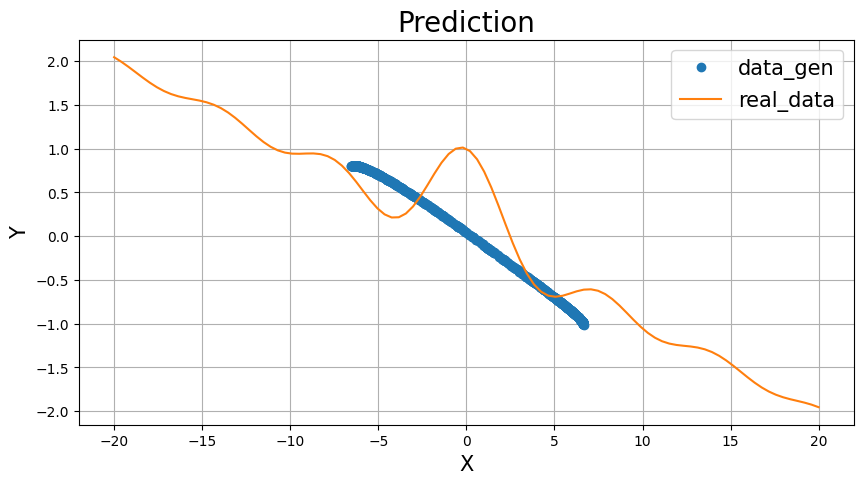

Epoch: 20; Discriminator_loss: 0.624; Generator_loss: 0.872


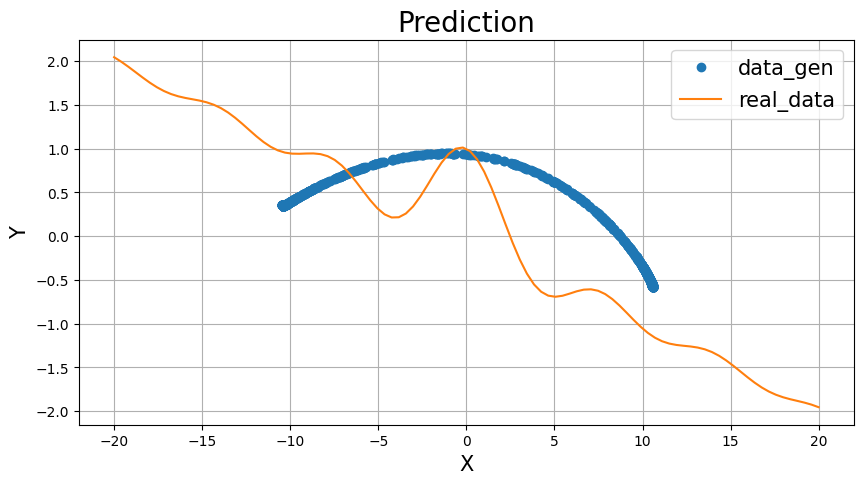

Epoch: 30; Discriminator_loss: 0.627; Generator_loss: 0.849


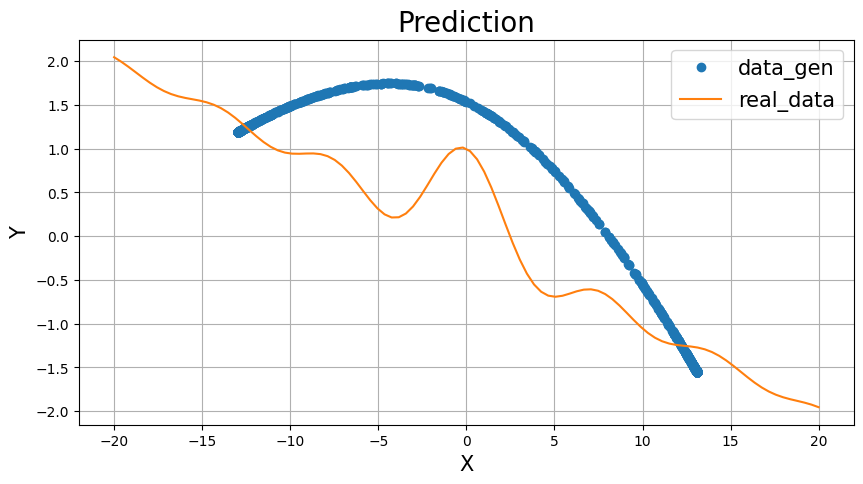

Epoch: 40; Discriminator_loss: 0.643; Generator_loss: 0.737


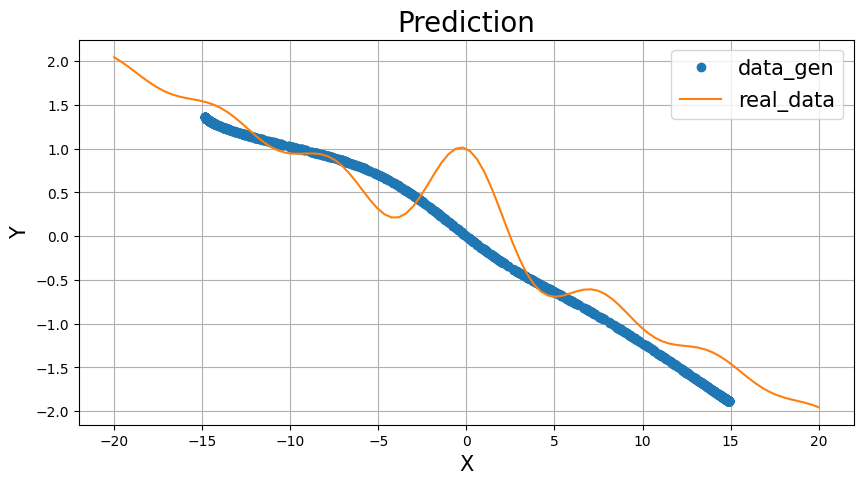

Epoch: 50; Discriminator_loss: 0.666; Generator_loss: 0.749


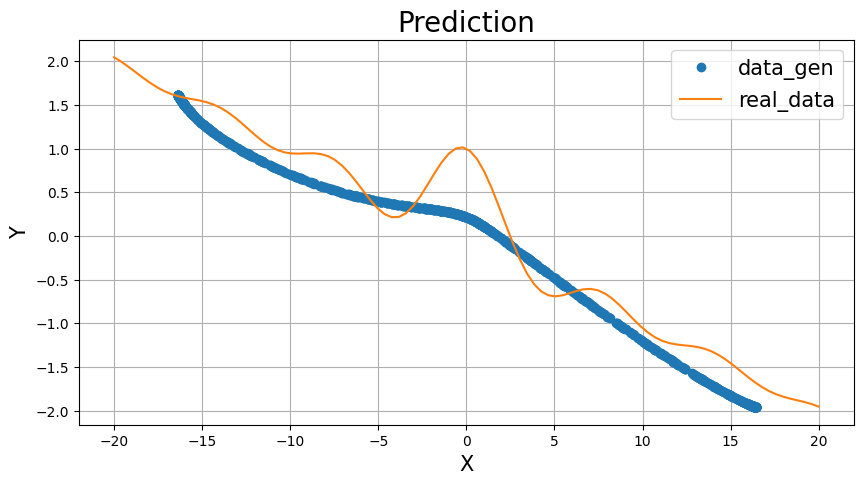

Epoch: 60; Discriminator_loss: 0.679; Generator_loss: 0.718


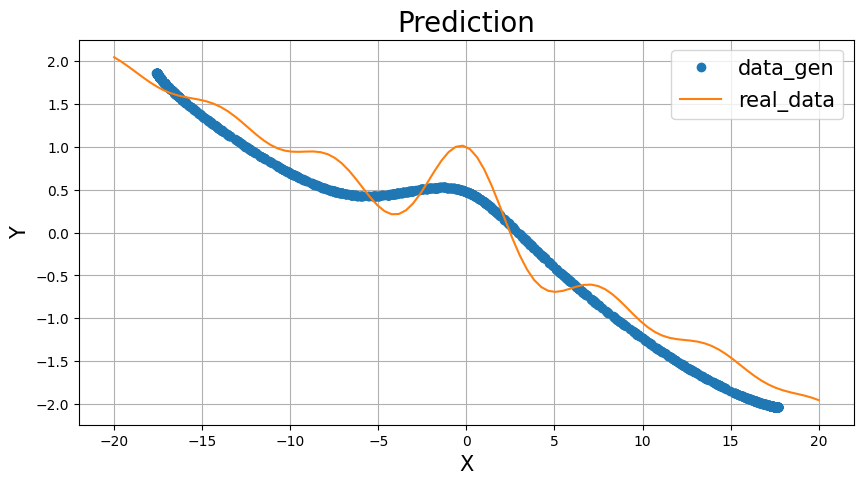

Epoch: 70; Discriminator_loss: 0.689; Generator_loss: 0.700


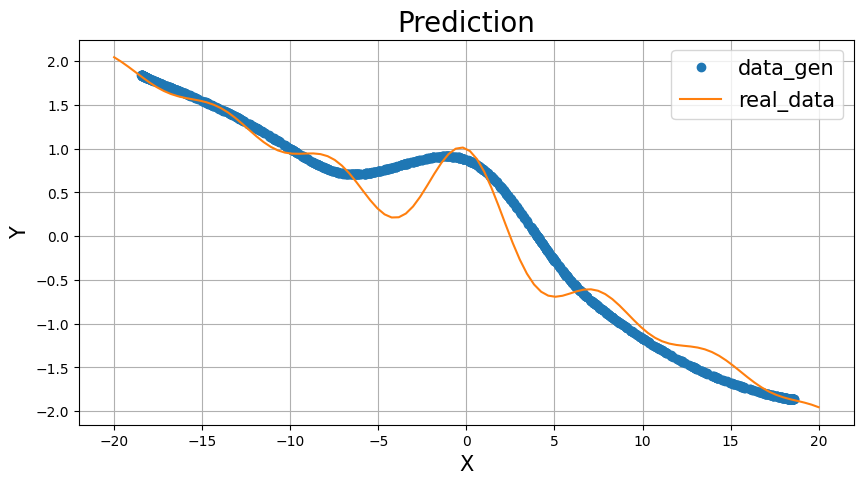

Epoch: 80; Discriminator_loss: 0.691; Generator_loss: 0.701


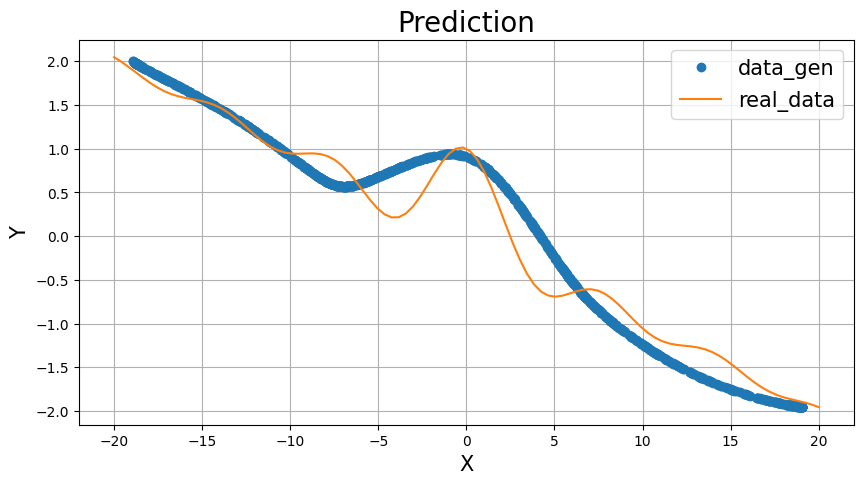

Epoch: 90; Discriminator_loss: 0.692; Generator_loss: 0.695


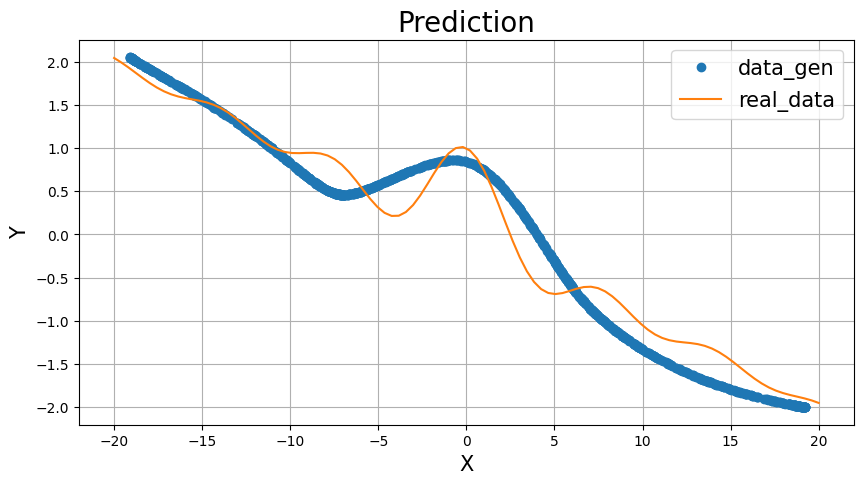

Epoch: 100; Discriminator_loss: 0.693; Generator_loss: 0.699


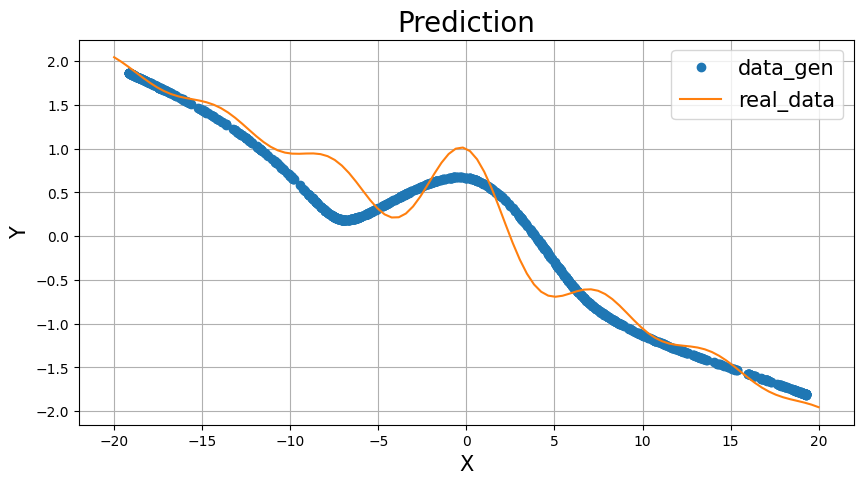

Epoch: 200; Discriminator_loss: 0.687; Generator_loss: 0.718


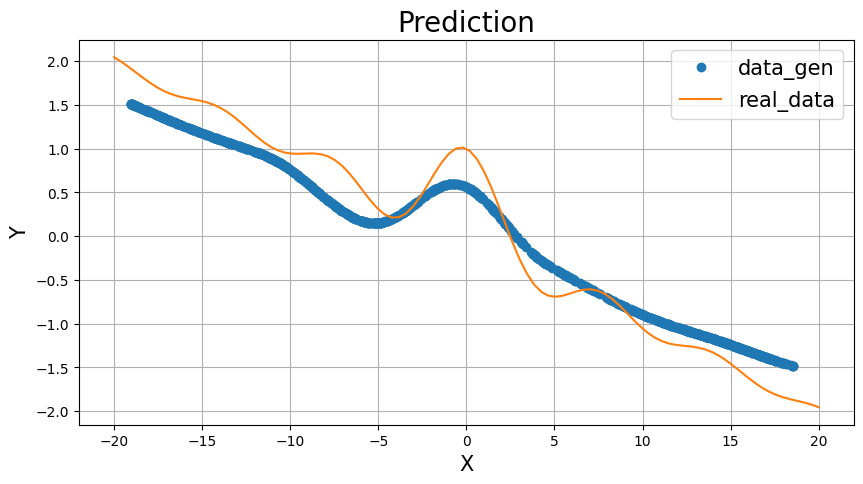

Epoch: 300; Discriminator_loss: 0.695; Generator_loss: 0.701


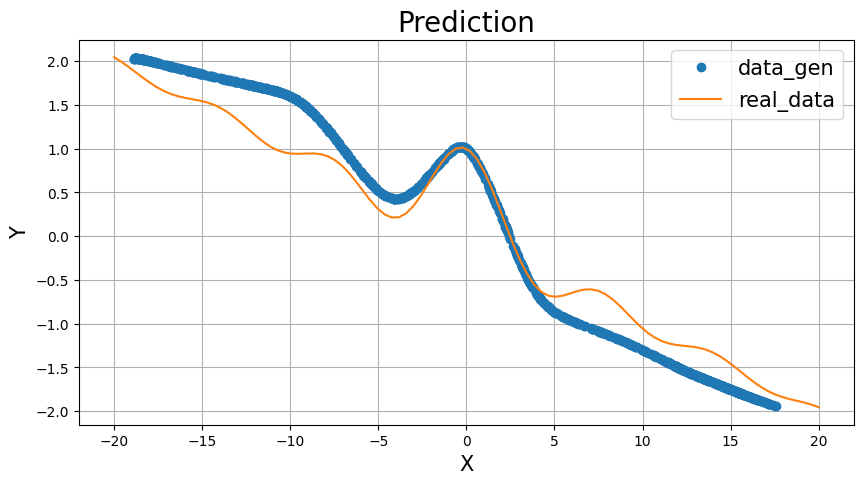

Epoch: 400; Discriminator_loss: 0.693; Generator_loss: 0.694


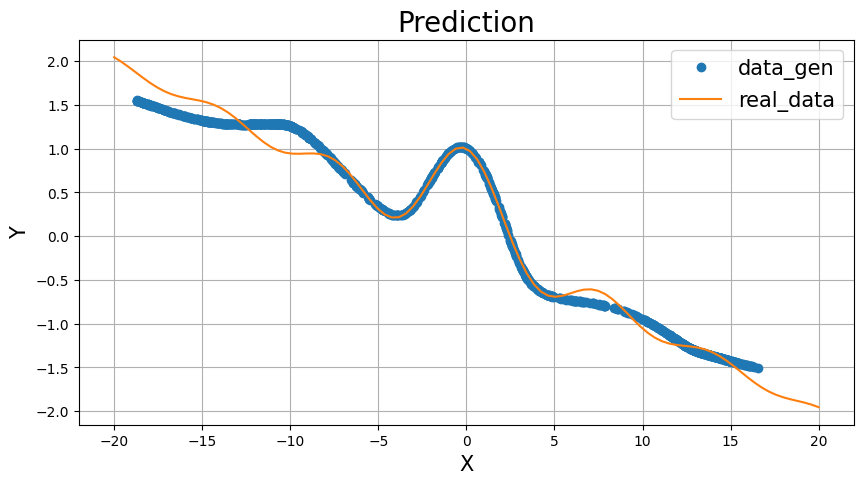

Epoch: 500; Discriminator_loss: 0.693; Generator_loss: 0.693


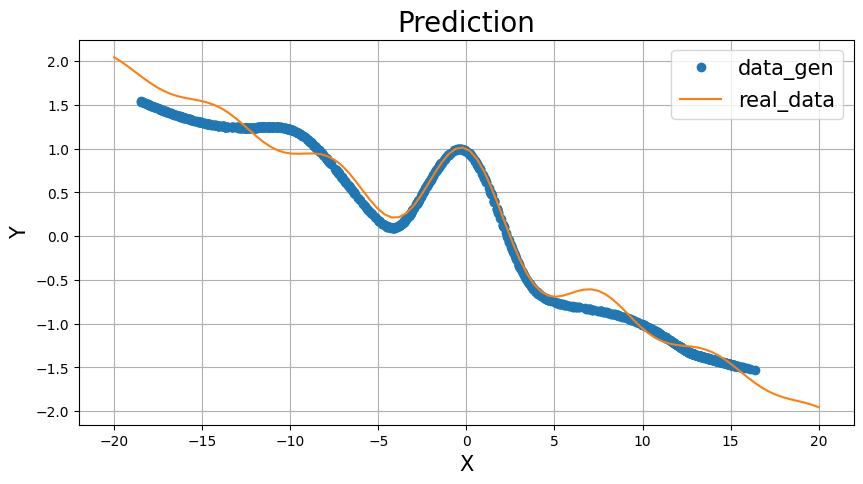

Epoch: 600; Discriminator_loss: 0.700; Generator_loss: 0.698


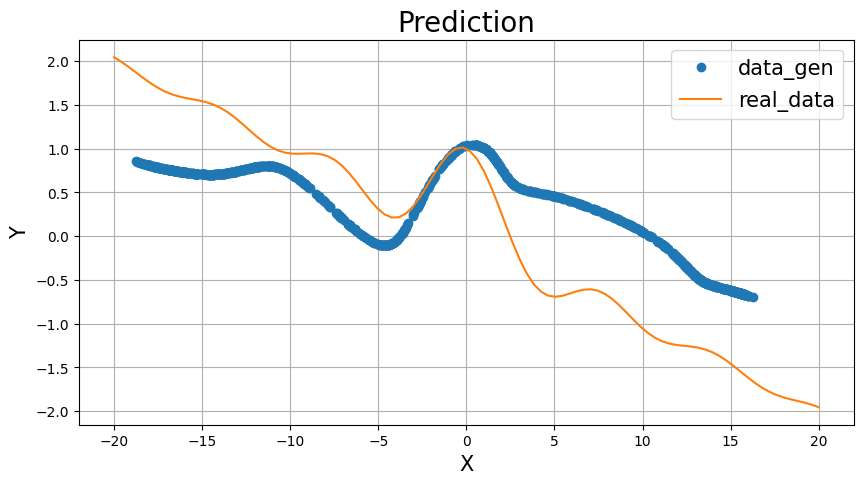

Epoch: 700; Discriminator_loss: 0.693; Generator_loss: 0.694


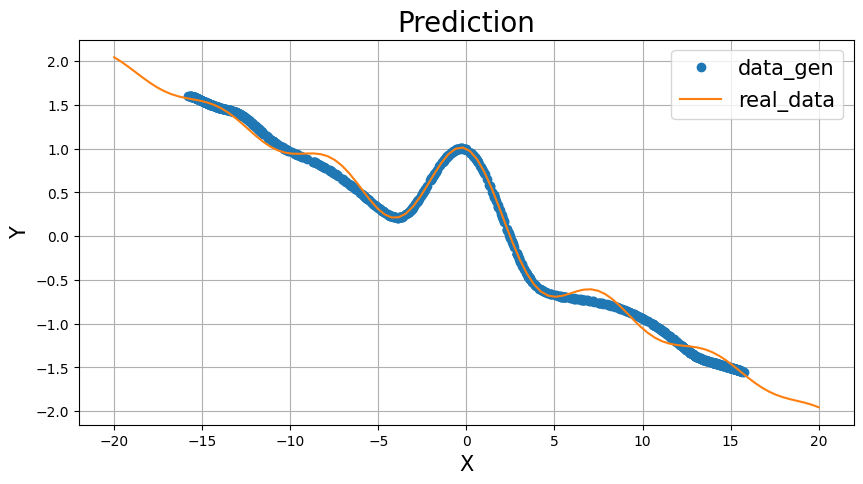

Epoch: 800; Discriminator_loss: 0.693; Generator_loss: 0.688


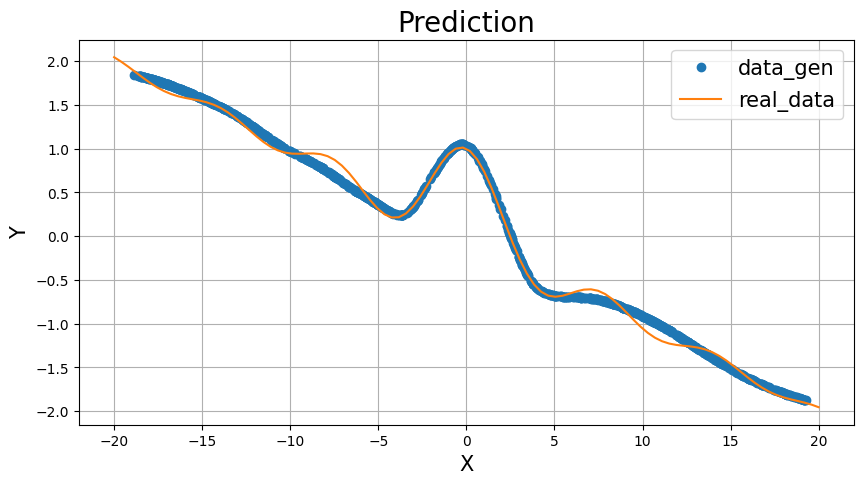

Epoch: 900; Discriminator_loss: 0.693; Generator_loss: 0.699


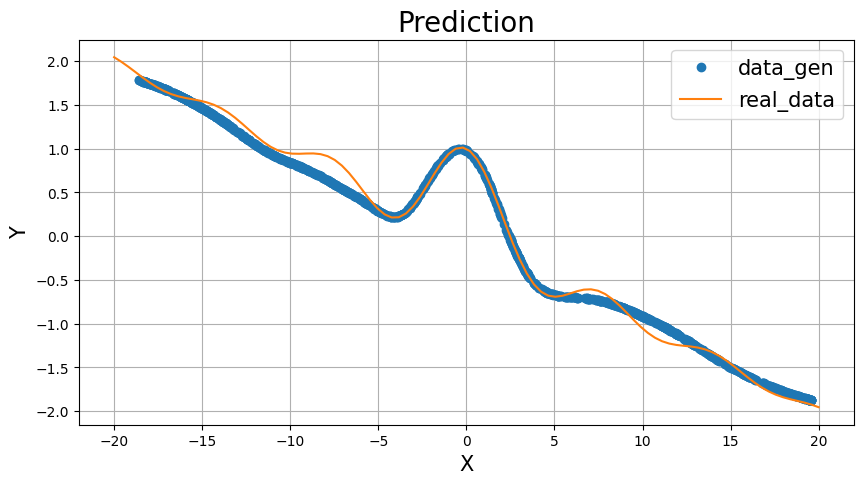

Epoch: 1000; Discriminator_loss: 0.693; Generator_loss: 0.691


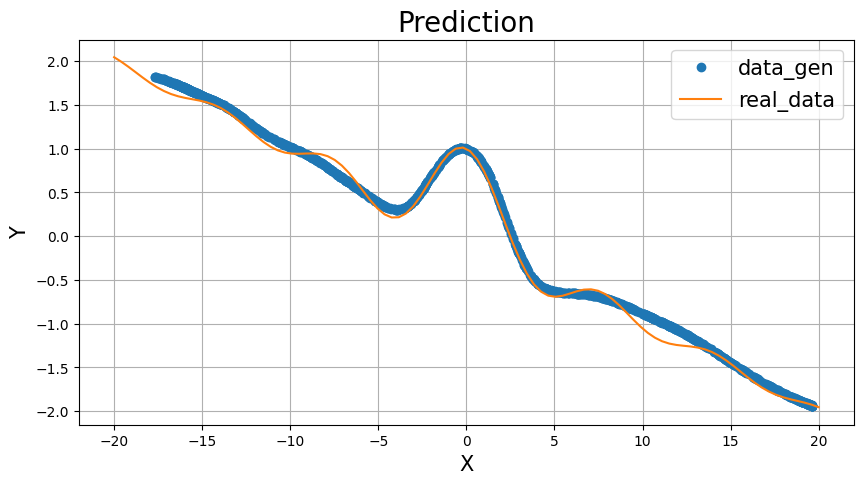

Epoch: 1100; Discriminator_loss: 0.693; Generator_loss: 0.695


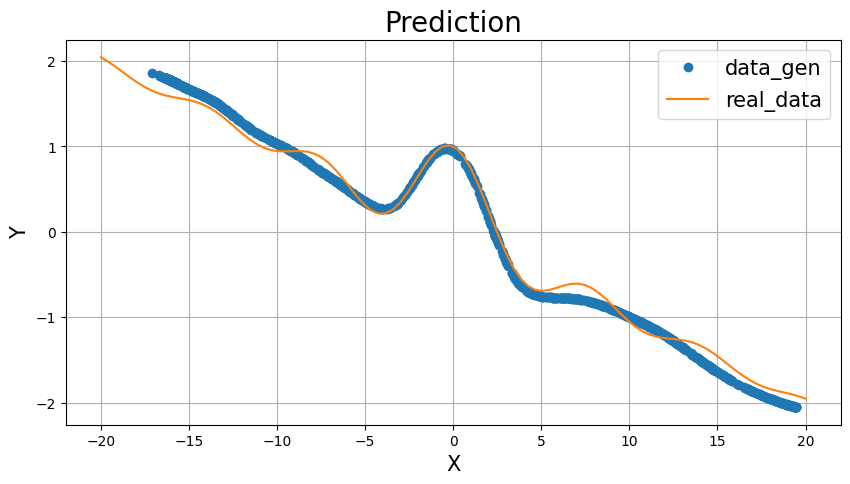

Epoch: 1200; Discriminator_loss: 0.693; Generator_loss: 0.695


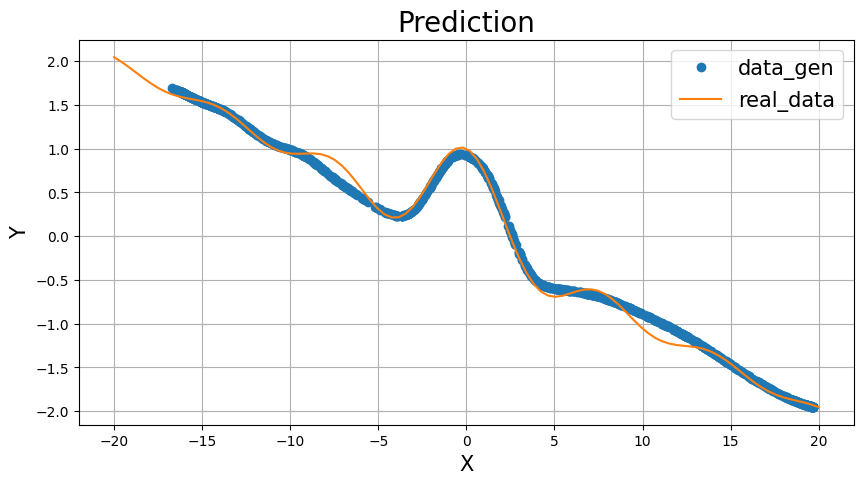

In [ ]:
dis_list, gen_list = model_train(num_epochs, data_loader, device, 1, common_loss, gen_optimizer, disc_optimizer, -20, 20)

## 10 Визуализация графика

Зависимость функций потерь генератора и дискриминатора друг относительно друга

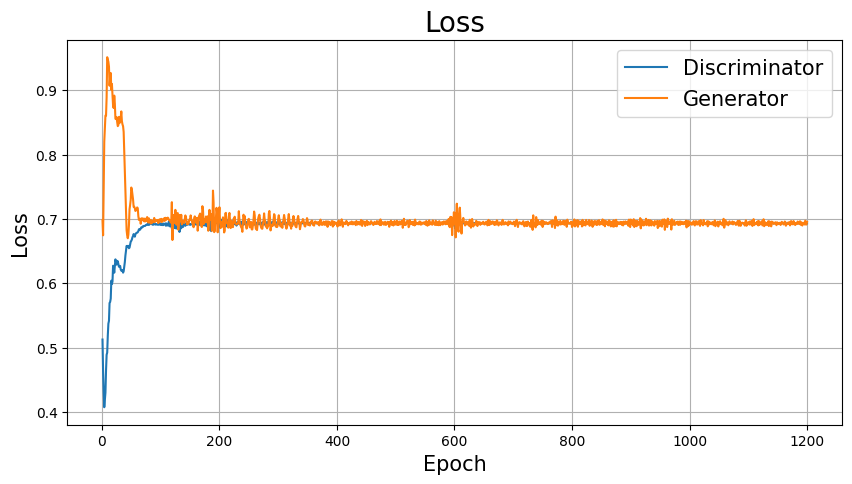

In [ ]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, num_epochs+1), dis_list, label='Discriminator')
plt.plot(range(1, num_epochs+1), gen_list, label='Generator')
plt.legend(fontsize = 15);

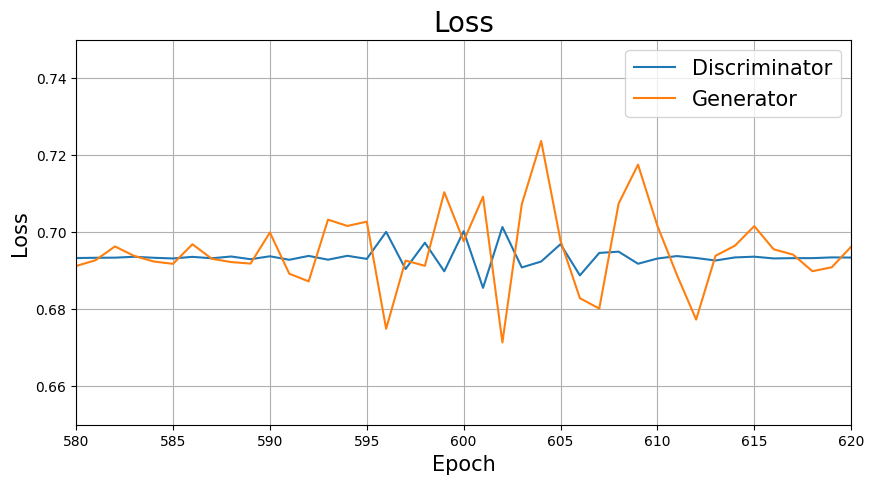

In [ ]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, num_epochs+1), dis_list, label='Discriminator')
plt.plot(range(1, num_epochs+1), gen_list, label='Generator')
plt.xlim((580, 620))
plt.ylim((0.65, 0.75))
plt.legend(fontsize = 15)